In [ ]:
!pip install opencv-python
!pip install keras_tuner

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/DL"

data_prep.ipynb			    hyper_rp_ankle_wrist.ipynb
fused_gaf_sd.zip		    modeling.ipynb
fused_images_rp_sd_ankle_wrist.zip  modeling_refactored_hyper.ipynb
fused_images_rp_summed_diff.zip     modeling_refactored.ipynb
gaf_conf_matrix.png		    rp_ankle_wrist_conf_matrix.png
gaf_train_val_loss.png		    rp_ankle_wrist_train_val_loss.png
hyper_gaf.ipynb			    summed_diff_images.zip


In [ ]:
# Defining paths to files
persistence_path = "/content/drive/My Drive/DL/" # TODO: replace me
working_directory = "/content/" # TODO: replace me (or not)

# Image only
zip_image_only_path = persistence_path + 'summed_diff_images.zip'
unzip_image_only_path = working_directory + 'image_only/'

# Image + GAF
zip_gaf_sd_path = persistence_path + 'fused_gaf_sd.zip'
unzip_gaf_sd_path = working_directory + 'fused_gaf_sd/'

# Image + RP (ankle acc, ankle gyro)
fused_images_zip_path = persistence_path + 'fused_images_rp_summed_diff.zip'
unzip_fused_images_path = working_directory + 'fused_images/'

# Image + RP (ankle acc, ankle gyro, wrist acc, wrist gyro)
zip_rp_sd_ankle_wrist_path = persistence_path + 'fused_images_rp_sd_ankle_wrist.zip'
unzip_rp_sd_ankle_wrist_path = working_directory + 'fused_images_rp_sd_ankle_wrist/'

In [ ]:
import os
import zipfile

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import keras_tuner as kt



# Check GPU availability
gpus_no = len(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", gpus_no)
# assert gpus_no >= 1, "You're not using a GPU, are you sure you want to proceed?"

Num GPUs Available:  1


In [ ]:
def load_data_from_path(trial_path):
    """
    Function that supports loading both images and already processed fused data
    merged of load_data_from_trial and load_fused_data
    """
    data = []
    labels = []
    skipped_files = []

    for root, _, files in os.walk(trial_path):
        for file in files:
            if file.endswith('.jpg'):
                file_path = os.path.join(root, file)

                # NOTE: moved this here because idk if file naming strategy is different between plain images and fused
                # it was in the loop above before refactor..
                # Extract activity label from the folder name
                try:
                    folder_name = os.path.basename(root)
                    activity_label = int([part for part in folder_name.split('_') if "Activity" in part][0].replace('Activity', '')) - 1
                except (IndexError, ValueError) as e:
                    skipped_files.append((root, str(e)))
                    continue

                try:
                    # Load the image and normalize to [0, 1]
                    image = plt.imread(file_path) / 255.0
                    data.append(image)
                    labels.append(activity_label)
                except Exception as e:
                    skipped_files.append((file_path, str(e)))

            # NOTE: the part from load_fused is here
            elif file.endswith('.npy'):
                file_path = os.path.join(root, file)
                fused_image = np.load(file_path)

                # Extract activity label from the parent folder structure
                try:
                    folder_name = os.path.basename(root)  # Example: Subject10_Activity10_Trial1
                    activity_part = folder_name.split("_")[1]  # Extracts 'Activity10'
                    activity_label = int(activity_part.replace('Activity', '')) - 1  # Convert to 0-based indexing

                    data.append(fused_image)
                    labels.append(activity_label)
                except (IndexError, ValueError) as e:
                    skipped_files.append((file_path, str(e)))

    # Log skipped files
    if skipped_files:
        print(f"Skipped {len(skipped_files)} files or folders due to errors:")
        for file_path, error in skipped_files[:10]:  # Limit output for clarity
            print(f"File or Folder: {file_path}, Error: {error}")

    return np.array(data), np.array(labels)


def split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path):
    """
    In the dataset, each subject makes three trials of the same activity,

    We use the third trial as test,
    and the first and second trials are merged and then randomly split into train and test sets
    """
    X_trial1, y_trial1 = load_data_from_path(trial1_path)
    X_trial2, y_trial2 = load_data_from_path(trial2_path)
    X_trial3, y_trial3 = load_data_from_path(trial3_path)

    # Combine trial1 and trial2 for training and validation
    X_train_val = np.concatenate((X_trial1, X_trial2), axis=0)
    y_train_val = np.concatenate((y_trial1, y_trial2), axis=0)

    # Use trial3 as the test set
    X_test, y_test = X_trial3, y_trial3

    # Split training and validation data
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

    # Print data shapes
    print("Training data shape:", X_train.shape, "Training labels shape:", y_train.shape)
    print("Validation data shape:", X_val.shape, "Validation labels shape:", y_val.shape)
    print("Test data shape:", X_test.shape, "Test labels shape:", y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

def unzip(zip_path, output_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(output_path)

In [ ]:
def build_model(hp):
    model = Sequential()

    # Input shape
    input_shape = (32, 32, 1)
    model.add(Conv2D(
        filters=hp.Int('conv_0_filters', 32, 256, step=32),
        kernel_size=hp.Choice('conv_0_kernel', [3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='log')),
        input_shape=input_shape,
        padding='same'  # Ensures output dimensions match input
    ))

    # Dynamically configurable convolutional layers
    for i in range(1, hp.Int('num_conv_layers', 1, 4)):
        model.add(Conv2D(
            filters=hp.Int(f'conv_{i}_filters', 32, 256, step=32),
            kernel_size=hp.Choice(f'conv_{i}_kernel', [3, 5]),
            activation='relu',
            kernel_regularizer=l2(hp.Float('l2_reg', 1e-4, 1e-2, sampling='log')),
            padding='same'  # Maintain spatial dimensions
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(Flatten())

    # Configurable dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', 64, 512, step=64),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'dense_l2_reg_{i}', 1e-4, 1e-2, sampling='log'))
        ))
        model.add(Dropout(hp.Float(f'dense_dropout_{i}', 0.1, 0.5, step=0.1)))

    model.add(Dense(num_classes, activation='softmax'))

    # Adaptive learning rate
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Only image data training

In [ ]:
unzip(zip_image_only_path, unzip_image_only_path)

# Paths to individual trial folders
trial1_path = os.path.join(unzip_image_only_path, 'trial1_summed_diff_images')
trial2_path = os.path.join(unzip_image_only_path, 'trial2_summed_diff_images')
trial3_path = os.path.join(unzip_image_only_path, 'trial3_summed_diff_images')

X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test_from_trials(trial1_path, trial2_path, trial3_path)

Training data shape: (3100, 32, 32) Training labels shape: (3100,)
Validation data shape: (776, 32, 32) Validation labels shape: (776,)
Test data shape: (1931, 32, 32) Test labels shape: (1931,)


Displaying samples from Training Set:


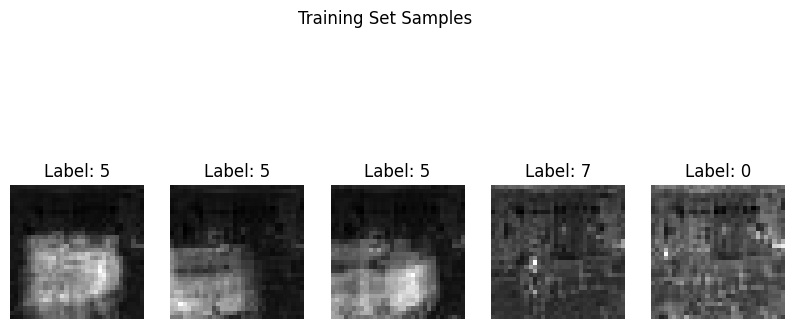

In [ ]:
# Display samples from the training set
def display_random_samples(X, y, title="Samples"):
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i], cmap='gray')  # Display the summed difference image
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

print("Displaying samples from Training Set:")
display_random_samples(X_train, y_train, title="Training Set Samples")

In [ ]:
# Initialize model
num_classes = len(np.unique(y_train))  # Number of activity classes
input_shape = X_train.shape[1:]  # Shape of one image

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Hyperband tuning strategy
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='only_image_activity_recognition',
    max_consecutive_failed_trials=100
)

# Search for best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.values)

# Train final model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
best_model. summary( )
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping]
)

Reloading Tuner from hyperparameter_tuning/activity_recognition/tuner0.json

Search: Running Trial #55

Value             |Best Value So Far |Hyperparameter
160               |192               |conv_0_filters
5                 |3                 |conv_0_kernel
0.00022437        |0.00010948        |l2_reg
1                 |2                 |num_conv_layers
1                 |1                 |num_dense_layers
512               |192               |dense_0_units
0.00082135        |0.00022043        |dense_l2_reg_0
0.3               |0.5               |dense_dropout_0
0.0015188         |0.0016548         |learning_rate
160               |96                |conv_1_filters
5                 |3                 |conv_1_kernel
0.3               |0.2               |dropout_1
96                |128               |conv_2_filters
3                 |3                 |conv_2_kernel
0.4               |0.4               |dropout_2
128               |96                |conv_3_filters
5             

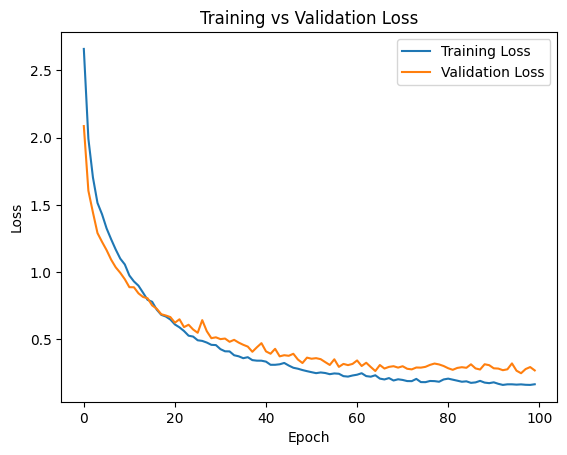

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot Training vs. Validation Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()
plt.savefig("image_train_val_loss.png")

In [ ]:
# Load the best model
# model.load_weights(checkpoint_path)

# Predict on the test set
y_pred = best_model.predict(X_test).argmax(axis=1)

# Classification report
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65        77
           1       0.81      0.56      0.67        78
           2       0.62      0.53      0.57        81
           3       0.65      0.81      0.72        79
           4       0.88      0.82      0.85        77
           5       1.00      1.00      1.00       336
           6       0.94      1.00      0.97       334
           7       1.00      0.98      0.99       335
           8       1.00      0.84      0.91        73
           9       0.99      1.00      1.00       154
          10       0.95      0.96      0.96       307

    accuracy                           0.92      1931
   macro avg       0.86      0.84      0.84      1931
weighted avg       0.92      0.92      0.92      1931



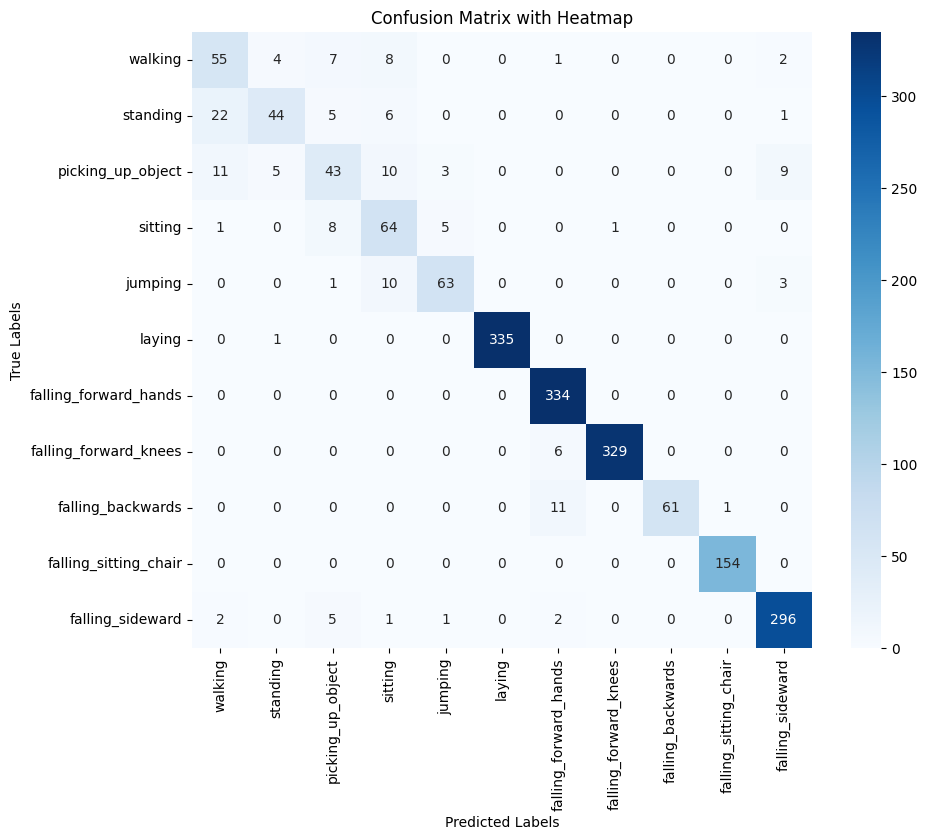

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

class_names = ['walking',
 'standing',
 'picking_up_object',
 'sitting',
 'jumping',
 'laying',
 'falling_forward_hands',
 'falling_forward_knees',
 'falling_backwards',
 'falling_sitting_chair',
 'falling_sideward']



# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix with Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
plt.savefig("image_conf_matrix")